[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ahmadmsbelbeisi/MLS/blob/main/MNIST_NN_from_scratch.ipynb)


# MNIST NN from scratch
---
####Machine Learning Seminar
#####Ahmad Belbeisi
######08/08/2022
---

In this notebook, We implemented a simple two-layer neural network and trained it on the MNIST digit recognizer dataset. It's meant to be an instructional example, through which you can understand the underlying math of neural networks better.


In [1]:
!pip install numpy pandas matplotlib wget


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import wget

In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB == True:
    if  os.path.exists("train.csv") and os.path.exists("test.csv") and  os.path.exists("sample_submission.csv"):
      pass
    else:
      !wget https://github.com/ahmadbelb/MLS/raw/main/digit-recognizer.zip
      if  not os.path.exists(os.getcwd() + "digit-recognizer.zip"):
          !unzip digit-recognizer.zip
else:
    if  os.path.exists("train.csv") and os.path.exists("test.csv") and  os.path.exists("sample_submission.csv"):
      pass
    else:
      if os.path.exists("digit-recognizer.zip"):
          print("Unzipping you files")
          !unzip digit-recognizer.zip
      else:
          print("Downloading yourfiles and Unziping")
          filename = wget.download("https://github.com/ahmadbelb/MLS/raw/main/digit-recognizer.zip")
          !unzip digit-recognizer.zip

In [4]:
datases = pd.read_csv('train.csv')

In [5]:
datases = np.array(datases)
m, n = datases.shape
np.random.shuffle(datases) # shuffle before splitting into dev and training sets

data_dev = datases[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = datases[1000:m].T
train_y = data_train[0]
train_x = data_train[1:n]
train_x = train_x / 255.
_,m_train = train_x.shape

In [6]:
train_y

array([3, 6, 0, ..., 6, 2, 3])

Our NN will have a simple two-layer architecture. Input layer $a^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $a^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $a^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [7]:
def initialize_weights_biases():
    Weight_1 = np.random.rand(10, 784) - 0.5
    bias_1 = np.random.rand(10, 1) - 0.5
    Weight_2 = np.random.rand(10, 10) - 0.5
    bias_2 = np.random.rand(10, 1) - 0.5
    return Weight_1, bias_1, Weight_2, bias_2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_propagation(Weight_1, bias_1, Weight_2, bias_2, X):
    Z1 = Weight_1.dot(X) + bias_1
    A1 = ReLU(Z1)
    Z2 = Weight_2.dot(A1) + bias_2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0


"""
Takes LongTensor with index values of shape (*) and returns a tensor of shape (*, num_classes)
that have zeros everywhere except where the index of last dimension matches the corresponding
value of the input tensor, in which case it will be 1.
"""
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_propagation(Z1, A1, Z2, A2, Weight_1, Weight_2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = Weight_2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(Weight_1, bias_1, Weight_2, bias_2, dW1, db1, dW2, db2, alpha):
    Weight_1 = Weight_1 - alpha * dW1
    bias_1 = bias_1 - alpha * db1
    Weight_2 = Weight_2 - alpha * dW2
    bias_2 = bias_2 - alpha * db2
    return Weight_1, bias_1, Weight_2, bias_2

In [8]:
def fetch_predictions(A2):
    return np.argmax(A2, 0)

def find_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    Weight_1, bias_1, Weight_2, bias_2 = initialize_weights_biases()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(Weight_1, bias_1, Weight_2, bias_2, X)
        dW1, db1, dW2, db2 = backward_propagation(Z1, A1, Z2, A2, Weight_1, Weight_2, X, Y)
        Weight_1, bias_1, Weight_2, bias_2 = update_params(Weight_1, bias_1, Weight_2, bias_2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = fetch_predictions(A2)
            print(find_accuracy(predictions, Y))
    return Weight_1, bias_1, Weight_2, bias_2

In [9]:
Weight_1, bias_1, Weight_2, bias_2 = gradient_descent(train_x, train_y, 0.10, 500)

Iteration:  0
[6 6 6 ... 2 5 6] [3 6 0 ... 6 2 3]
0.08275609756097561
Iteration:  10
[6 5 6 ... 2 5 3] [3 6 0 ... 6 2 3]
0.1608048780487805
Iteration:  20
[3 5 2 ... 2 5 3] [3 6 0 ... 6 2 3]
0.21092682926829268
Iteration:  30
[3 5 2 ... 2 5 3] [3 6 0 ... 6 2 3]
0.2754878048780488
Iteration:  40
[3 5 2 ... 2 6 9] [3 6 0 ... 6 2 3]
0.3275609756097561
Iteration:  50
[3 5 0 ... 2 6 9] [3 6 0 ... 6 2 3]
0.37397560975609756
Iteration:  60
[3 8 0 ... 2 6 9] [3 6 0 ... 6 2 3]
0.4191951219512195
Iteration:  70
[3 8 0 ... 2 6 9] [3 6 0 ... 6 2 3]
0.47792682926829266
Iteration:  80
[3 8 0 ... 2 6 9] [3 6 0 ... 6 2 3]
0.5433414634146342
Iteration:  90
[3 8 0 ... 6 6 9] [3 6 0 ... 6 2 3]
0.5932195121951219
Iteration:  100
[3 8 0 ... 6 6 9] [3 6 0 ... 6 2 3]
0.6305853658536585
Iteration:  110
[3 8 0 ... 6 6 3] [3 6 0 ... 6 2 3]
0.6577560975609756
Iteration:  120
[3 8 0 ... 6 6 3] [3 6 0 ... 6 2 3]
0.6803170731707318
Iteration:  130
[3 8 0 ... 6 6 3] [3 6 0 ... 6 2 3]
0.6992682926829268
Iteration:  1

~85% accuracy on training set.

In [10]:
def make_predictions(X, Weight_1, bias_1, Weight_2, bias_2):
    _, _, _, A2 = forward_propagation(Weight_1, bias_1, Weight_2, bias_2, X)
    predictions = fetch_predictions(A2)
    return predictions

def test_prediction(index, Weight_1, bias_1, Weight_2, bias_2):
    current_image = train_x[:, index, None]
    prediction = make_predictions(train_x[:, index, None], Weight_1, bias_1, Weight_2, bias_2)
    label = train_y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Let's look at a couple of examples:

Prediction:  [3]
Label:  3


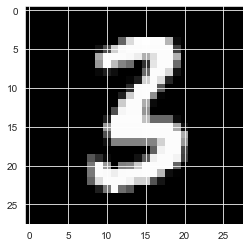

Prediction:  [6]
Label:  6


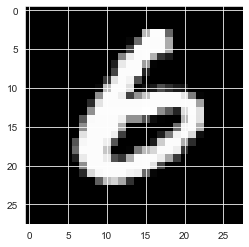

Prediction:  [0]
Label:  0


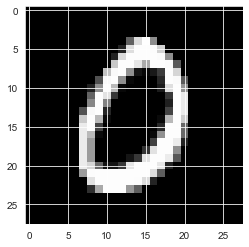

Prediction:  [6]
Label:  6


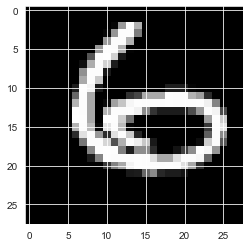

In [11]:
test_prediction(0, Weight_1, bias_1, Weight_2, bias_2)
test_prediction(1, Weight_1, bias_1, Weight_2, bias_2)
test_prediction(2, Weight_1, bias_1, Weight_2, bias_2)
test_prediction(3, Weight_1, bias_1, Weight_2, bias_2)

Finally, let's find the accuracy on the dev set:

In [12]:
dev_predictions = make_predictions(X_dev, Weight_1, bias_1, Weight_2, bias_2)
find_accuracy(dev_predictions, Y_dev)

[7 1 5 7 0 4 8 6 7 5 1 8 7 8 8 0 7 6 4 8 6 1 8 0 1 3 0 6 0 0 4 2 1 6 5 3 7
 3 3 0 8 0 8 4 9 1 5 4 1 9 3 1 9 0 5 8 2 3 5 7 7 0 7 0 9 1 7 7 9 9 7 5 4 0
 2 0 5 8 1 5 7 7 9 2 3 1 7 2 7 7 1 6 6 7 1 5 1 3 6 9 6 6 7 8 0 3 0 7 6 3 0
 9 4 3 3 4 5 2 7 7 3 2 8 9 5 5 3 2 1 1 3 8 1 9 6 2 5 9 1 1 6 1 7 8 0 8 3 0
 9 0 8 4 6 3 8 6 8 3 4 6 1 7 2 8 1 0 9 9 6 0 7 5 7 7 8 2 7 8 3 1 6 2 9 8 5
 9 0 2 9 1 8 8 6 1 7 3 7 5 7 3 1 1 1 4 5 8 3 3 9 7 2 4 2 7 2 7 3 1 6 1 5 3
 1 5 9 9 1 9 0 5 5 1 6 6 4 1 4 5 7 8 7 6 7 1 8 8 3 9 5 9 6 2 5 6 1 9 6 2 7
 6 5 1 6 1 4 5 1 2 9 3 7 4 1 5 2 8 2 0 2 2 3 8 3 0 7 1 9 4 7 0 6 2 8 4 4 1
 2 8 8 7 0 1 6 8 3 3 1 4 7 2 1 3 5 0 2 1 4 6 3 5 8 7 5 8 6 1 6 6 3 2 1 0 6
 8 8 5 0 2 7 4 1 8 6 7 3 6 8 2 2 1 0 8 0 2 3 3 8 3 1 5 7 0 5 6 4 8 4 0 2 8
 0 3 0 1 0 7 4 9 5 8 8 1 7 6 0 2 4 1 7 9 5 0 0 9 7 4 2 2 9 1 5 3 6 7 4 8 5
 3 1 9 8 1 6 8 8 7 4 3 8 4 3 5 5 2 6 5 4 6 3 1 0 5 4 7 5 2 1 5 1 2 2 4 7 0
 1 4 5 4 2 7 3 2 6 7 9 4 7 0 7 2 6 6 3 3 2 7 7 6 0 2 4 1 4 4 2 9 0 0 3 0 2
 2 1 1 8 8 1 6 6 4 7 1 9 

0.836

Still 84% accuracy, so our model generalized from the training datases pretty well.